In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 2

from compton.spectrum import Trajectory, Spectrum

In [9]:
#Create an instance of Trajectory class and calculate a trajectory

u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters
tau = 10 * 2 * np.pi  # Pulse duration
a0 = 1               # Pulse amplitude
mode = 'rectangle'       # Temporal envelope
polarization = 'circular'

def envelope(x, mode='gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)])
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)])

eta_b = 1.*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

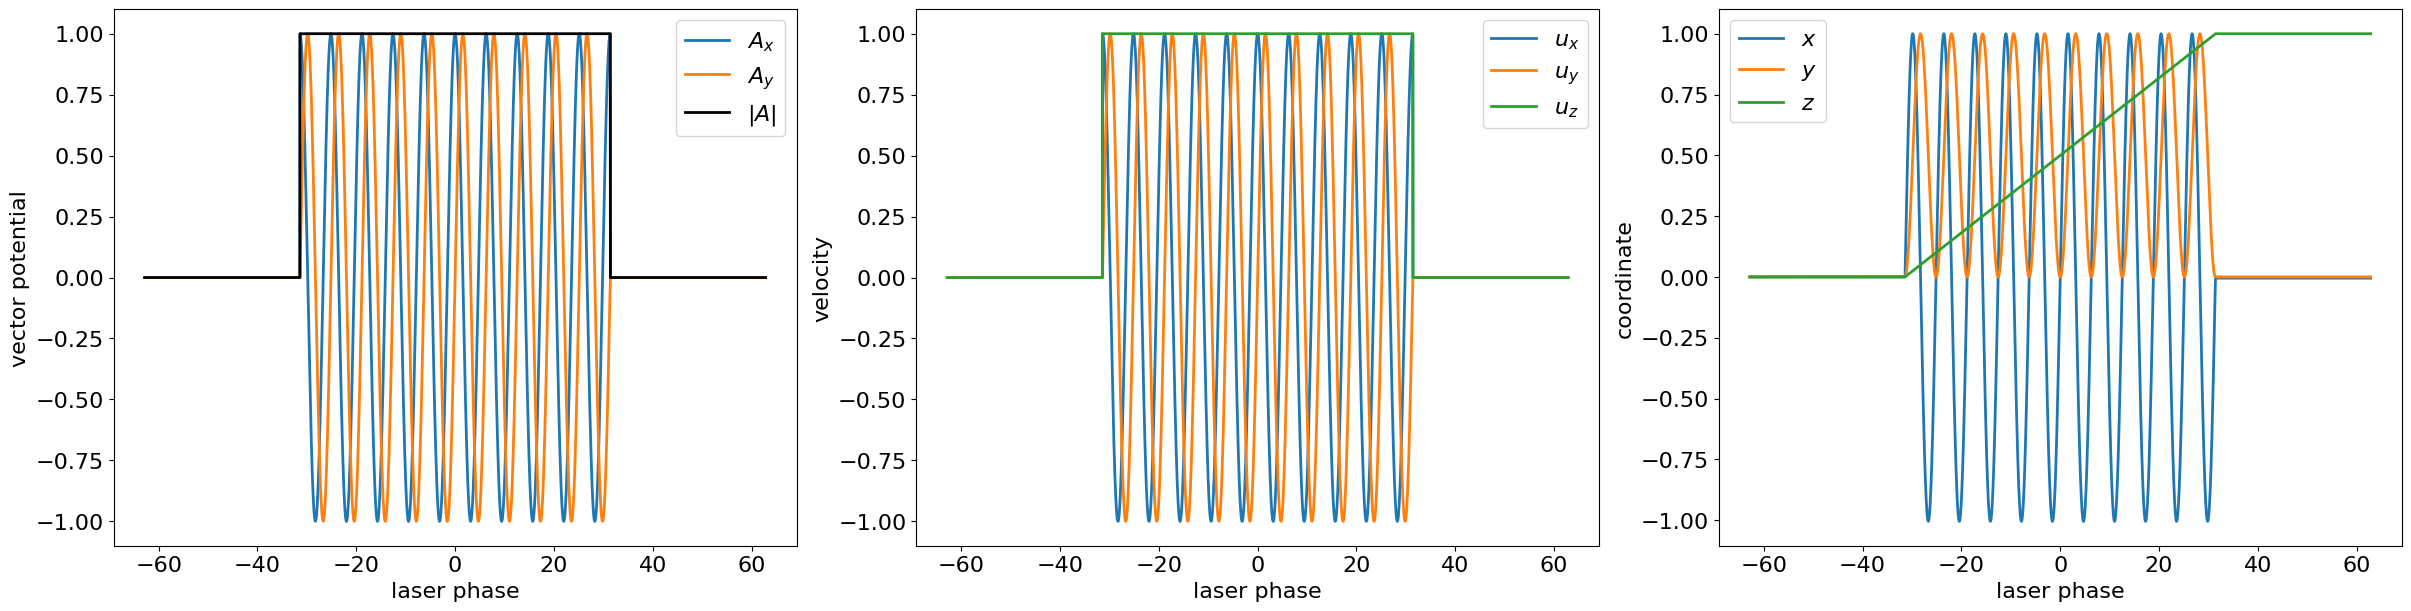

In [10]:
# Plot electron velocity and coordinate

A_mod = np.sqrt(A[0]**2 + A[1]**2)

plt.figure(figsize=(24, 6), layout='constrained')
plt.subplot(1,3,1)
plt.plot(eta, A[0]/np.max(A[0]), label='$A_x$')
plt.plot(eta, A[1]/np.max(A[1]), label='$A_y$')
plt.plot(eta, A_mod/np.max(A_mod), label='$|A|$', color='black')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('vector potential')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(1,3,2)
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(1,3,3)
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [11]:
# Create an instance of Spectrum class and calculate the emission spectrum based on trajectories
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

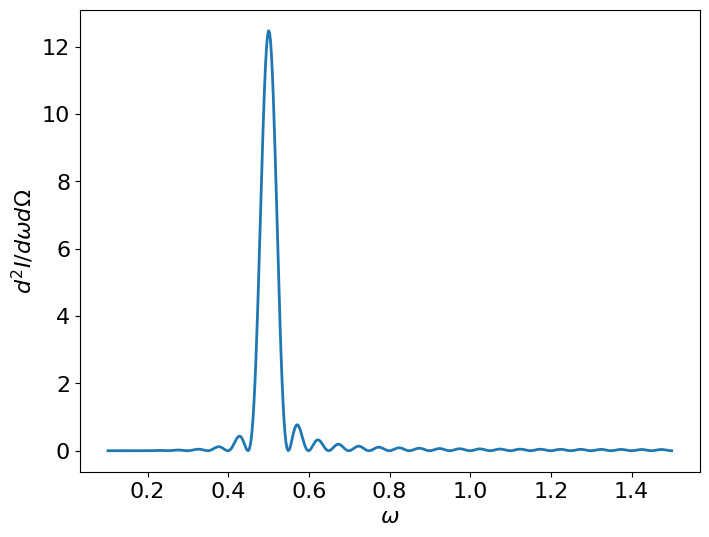

In [12]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(w_plot, I_plot)
plt.xlabel('$\\omega$')
plt.ylabel('$d^2 I / d\\omega d\\Omega$')
plt.show()